<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
sns.set()
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

MessageError: ignored

In [ ]:
data_path = '/content/drive/MyDrive/Shared Folder/OIS/'

def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  quarters = np.floor((month_number - 12*years)/3)
  months = (month_number - 12*years - quarters*3)

  y_str = f"{int(years)}Y" * int(years > 0)
  q_str = f"{int(quarters)}Q" * int(quarters > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + q_str + m_str


ois = pd.read_csv(os.path.join(data_path, 'OIS spot.csv'),
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois*100.0

ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

ois.tail()

,1M,2M,1Q,1Q1M,1Q2M,2Q,2Q1M,2Q2M,3Q,3Q1M,...,4Y1Q,4Y1Q1M,4Y1Q2M,4Y2Q,4Y2Q1M,4Y2Q2M,4Y3Q,4Y3Q1M,4Y3Q2M,5Y
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-25,35.119972,41.341829,46.843968,52.582282,58.416396,64.115164,69.516759,74.541287,79.171703,83.425822,...,121.718811,121.521181,121.317019,121.107352,120.893113,120.675151,120.454238,120.231077,120.006306,119.780505
2022-01-26,35.851313,41.879225,47.410196,53.203449,59.109268,64.900687,70.416986,75.571496,80.336346,84.719257,...,124.215521,124.009294,123.796279,123.577688,123.354640,123.128171,122.899242,122.668742,122.437498,122.206277
2022-01-27,37.443231,43.669903,49.598708,55.722871,61.903654,67.949098,73.715533,79.117787,84.123006,88.734499,...,126.712434,126.442866,126.168575,125.890711,125.610337,125.328441,125.045944,124.763699,124.482502,124.203097
2022-01-28,38.117194,44.246363,50.314618,56.669277,63.107294,69.396786,75.378020,80.957231,86.099408,90.811473,...,129.730892,129.504323,129.272569,129.036536,128.797040,128.554816,128.310522,128.064749,127.818028,127.570827
2022-01-31,41.430899,46.970661,53.190000,59.876511,66.677832,73.289540,79.531077,85.316363,90.636180,95.527643,...,136.564124,136.250863,135.933687,135.613745,135.292066,134.969572,134.647085,134.325334,134.004969,133.686562


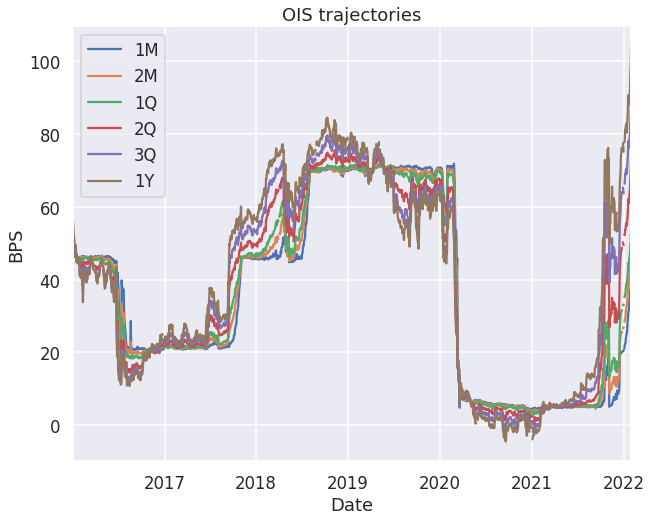

In [ ]:
tenor_subset = ['1M', '2M', '1Q', '2Q', '3Q', '1Y']
df = ois[tenor_subset]
df.plot()
plt.ylabel('BPS')
plt.xlabel('Date')
_ = plt.title('OIS trajectories')

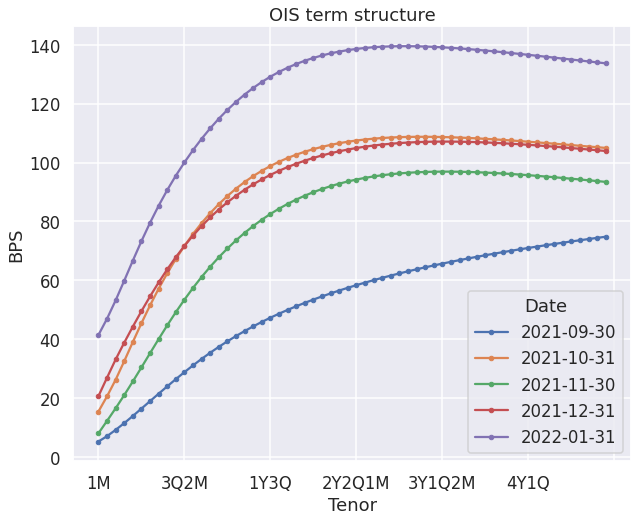

In [ ]:
term_structure_df = ois.tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')

<BarContainer object of 6 artists>

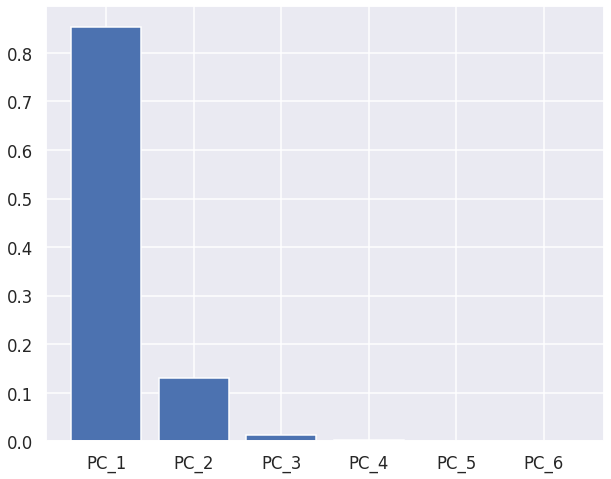

In [ ]:
pca = PCA()
pca.fit(df.diff().dropna())

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
plt.bar(x = exp_var.index, height = exp_var['Explained variance'])

In [ ]:
exp_var

,Explained variance
PC_1,0.852961
PC_2,0.130912
PC_3,0.013179
PC_4,0.002546
PC_5,0.000337
PC_6,0.000064
